1. Setup

1.1 Using Colab GPU for Training


Run the following the cell to confirm the GPU is detected.

In [1]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In order for torch to use the GPU, we need to identify and specify the GPU as the device. Later, in out training loop

In [2]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


1.2 Installing Hugging Face Library

In [3]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


2. Loading Dataset

2.1 Mount Google Drive

In [4]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [5]:
%cd
!pwd
%cd /content/gdrive/MyDrive/nlp-physicseducation/

/root
/root
/content/gdrive/MyDrive/nlp-physicseducation


2.2 Parse Data

In [6]:
import pandas as pd

# load the dataset into a pandas dataframe
df = pd.read_csv(
    'outputs/labels_cleaned_y1c1c2.csv', encoding='utf-8', skiprows = 1, 
    names=['StudentID', 'Content', 'ArgumentLevel', 'ReasoningLevel']
)

# Report the number of reports
print('Number of reports: {:,}\n'.format(df.shape[0]))

# Display 10 random rows from the data
df.sample(10)

Number of reports: 95



,StudentID,Content,ArgumentLevel,ReasoningLevel
73,GS_BPP712_Redacted,the rydberg constant relates the wavelength of...,expert,the
9,GS_VLS445_Redacted,a of recent time the rydberg be one of the mos...,superficial,none
31,GS_BQD756_Redacted,can be consider accurate furthermore a the per...,expert,bal
75,GS_SUY577_Redacted,the rydberg constant be a constant which appea...,extended,bal
46,GS_NQR167_Redacted,the rydberg constant have connection with many...,extended,bal
55,GS_NHZ839_Redacted,spectroscopy be one of the most powerful tool ...,superficial,the
80,GS_XUL605_Redacted,through the use of a grate spectrometer with a...,extended,the
78,GS_NPG050_Redacted,the aim of the experiment be to measure the sp...,superficial,bal
52,GS_EIW693_Redacted,in the follow experiment the rydberg constant ...,extended,the
81,GS_UGX035_Redacted,troscopy method with a hydrogen lamp the aim b...,deep,bal


The label 'ArgumentLevel' and 'ReasoningLevel' are mapped to numbers.

Argument Level labels {'bal': 0, 'the': 1, 'exp': 2, 'none': 3}

Reasoning Level labels {'extended': 0, 'deep': 1, 'expert': 2, 'superficial': 3, 'prediction': 4}

In [7]:
# define dict to code labels to numbers
ReasoningLevel_dict = {'bal': 0, 'the': 1, 'exp': 2, 'none': 3}
ArgumentLevel_dict = {'extended': 0, 'deep': 1, 'expert': 2, 'superficial': 3, 'prediction': 4}

# replace to number labels
df['ReasoningLevel'].replace(list(ReasoningLevel_dict.keys()), list(ReasoningLevel_dict.values()),inplace=True) 
df['ArgumentLevel'].replace(list(ArgumentLevel_dict.keys()), list(ArgumentLevel_dict.values()),inplace=True) 


# Display 10 random rows from the data
df.sample(10)

,StudentID,Content,ArgumentLevel,ReasoningLevel
61,GS_WEM893_Redacted,in 1911 neils bohr use quantum theory to expla...,3,0
18,GS_JSR480_Redacted,the rydberg constant rh be measure use a grate...,0,0
22,GS_TAP080_Redacted,in this experiment we use a grate spectrometer...,4,0
29,GS_PHU922_Redacted,the rydberg constant r∞ relates the wavelength...,1,1
70,GS_GQV977_Redacted,use a hydrogen lamp and by passing it emit lig...,1,1
39,GS_DAR896_Redacted,the follow paper explores how an optical diffr...,3,1
13,GS_LZH215_Redacted,abstract-the main aim of this experiment be to...,1,1
8,GS_LEH982_Redacted,we observe the ray of emission of hydrogen ato...,3,1
47,GS_RAK801_Redacted,in this experiment we found an estimate of the...,3,0
36,GS_FVA673_Redacted,the rydberg constant be calculate by observe t...,0,0


Let's extract the sentences and labels of our training set as numpy ndarrys.

In [8]:
corpus = df.Content.values
ArgumentLevels = df.ArgumentLevel.values
ReasoningLevels = df.ReasoningLevel.values

print('Number of reports: {:,}\n'.format(len(corpus)))
print(corpus)

Number of reports: 95

["where z be the atom 's atomic number 𝜀 0 be the vacuum permittivity me be the electron 's mass and e be the charge of the electron if we divide eq 2.2 by eq 2 2.6 where v and t be potential the kinetic energy of electron respectively 5 since the energy of a photon emit by a hydrogen atom be give by the difference of two hydrogen energy level where n and m be positive integer and n be great than m. from the relationship between wavelength and frequency of a photon 𝜈 𝑐 𝜆 2.9 where c be the speed of light eq 6 can be rewrite a for hydrogen atom the atomic number z be 1. therefore the rydberg constant be define a in this experiment we experimentally measure the rydberg constant if hydrogen gas be heat or electrically charge the electron in the atom be excite and the add energy push the electron to high energy orbitals when the electron fall back to their original position the add energy be re-emitted in the form of photon and the wavelength of the photon be determi

3. Tokenization & Input Formatting

In this section, we'll transform our dataset into the format that BERT can be trained on.

3.1 BERT Tokenizer

To feed our text to BERT, it must be split into tokens, and then these tokens must be mapped to their index in the tokenizer vocabulary.

The tokenization must be performed by the tokenizer included with BERT--the below cell will download this for us. We'll be using the "uncased" version here.

In [9]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


Let's apply the tokenizer to one report just to see the output.

In [10]:
# Print the original report.
print('length:',len(corpus[0]),';  Original: ', corpus[0])

# Print the report split into tokens.
print('length:',len(tokenizer.tokenize(corpus[0])),';  Tokenized: ', tokenizer.tokenize(corpus[0]))

# Print the report mapped to token ids.
print('length:',len(tokenizer.convert_tokens_to_ids(tokenizer.tokenize(corpus[0]))) , ';  Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(corpus[0])))

length: 3496 ;  Original:  where z be the atom 's atomic number 𝜀 0 be the vacuum permittivity me be the electron 's mass and e be the charge of the electron if we divide eq 2.2 by eq 2 2.6 where v and t be potential the kinetic energy of electron respectively 5 since the energy of a photon emit by a hydrogen atom be give by the difference of two hydrogen energy level where n and m be positive integer and n be great than m. from the relationship between wavelength and frequency of a photon 𝜈 𝑐 𝜆 2.9 where c be the speed of light eq 6 can be rewrite a for hydrogen atom the atomic number z be 1. therefore the rydberg constant be define a in this experiment we experimentally measure the rydberg constant if hydrogen gas be heat or electrically charge the electron in the atom be excite and the add energy push the electron to high energy orbitals when the electron fall back to their original position the add energy be re-emitted in the form of photon and the wavelength of the photon be deter

When we actually convert all of our sentences, we'll use the `tokenize.encode` function to handle both steps, rather than calling `tokenize` and `convert_tokens_to_ids` separately. 

Before we can do that, though, we need to talk about some of BERT's formatting requirements.

3.2. Required Formatting

The above code left out a few required formatting steps that we'll look at here.

We are required to:
1. Add special tokens to the start and end of each sentence.
2. Pad & truncate all sentences to a single constant length.
3. Explicitly differentiate real tokens from padding tokens with the "attention mask".

Special Tokens


**`[SEP]`**

At the end of every sentence, we need to append the special `[SEP]` token. 

This token is an artifact of two-sentence tasks, where BERT is given two separate sentences and asked to determine something (e.g., can the answer to the question in sentence A be found in sentence B?). 

I am not certain yet why the token is still required when we have only single-sentence input, but it is!


**`[CLS]`**

For classification tasks, we must prepend the special `[CLS]` token to the beginning of every sentence.

This token has special significance. BERT consists of 12 Transformer layers. Each transformer takes in a list of token embeddings, and produces the same number of embeddings on the output (but with the feature values changed, of course!).

![Illustration of CLS token purpose](https://drive.google.com/uc?export=view&id=1ck4mvGkznVJfW3hv6GUqcdGepVTOx7HE)

On the output of the final (12th) transformer, *only the first embedding (corresponding to the [CLS] token) is used by the classifier*.

>  "The first token of every sequence is always a special classification token (`[CLS]`). The final hidden state
corresponding to this token is used as the aggregate sequence representation for classification
tasks." (from the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf))

You might think to try some pooling strategy over the final embeddings, but this isn't necessary. Because BERT is trained to only use this [CLS] token for classification, we know that the model has been motivated to encode everything it needs for the classification step into that single 768-value embedding vector. It's already done the pooling for us!




Sentence Length & Attention Mask

The sentences in our dataset obviously have varying lengths, so how does BERT handle this?

BERT has two constraints:
1. All sentences must be padded or truncated to a single, fixed length.
2. The maximum sentence length is 512 tokens.

Padding is done with a special `[PAD]` token, which is at index 0 in the BERT vocabulary. The below illustration demonstrates padding out to a "MAX_LEN" of 8 tokens.

<img src="https://drive.google.com/uc?export=view&id=1cb5xeqLu_5vPOgs3eRnail2Y00Fl2pCo" width="600">

The "Attention Mask" is simply an array of 1s and 0s indicating which tokens are padding and which aren't (seems kind of redundant, doesn't it?!). This mask tells the "Self-Attention" mechanism in BERT not to incorporate these PAD tokens into its interpretation of the sentence.

The maximum length does impact training and evaluation speed, however. 
For example, with a Tesla K80:

`MAX_LEN = 128  -->  Training epochs take ~5:28 each`

`MAX_LEN = 64   -->  Training epochs take ~2:57 each`


3.3 Tokenise Dataset

The transformers library provides a helpful `encode` function which will handle most of the parsing and data prep steps for us.

Before we are ready to encode our text, though, we need to decide on a **maximum sentence length** for padding / truncating to.

The below cell will perform one tokenization pass of the dataset in order to measure the maximum sentence length.

In [11]:
'''
max_len = 0

# For every report...
for content in contents:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(content, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)
'''

"\nmax_len = 0\n\n# For every report...\nfor content in contents:\n\n    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.\n    input_ids = tokenizer.encode(content, add_special_tokens=True)\n\n    # Update the maximum sentence length.\n    max_len = max(max_len, len(input_ids))\n\nprint('Max sentence length: ', max_len)\n"

Our documents has tokens > 512. As a BERT test, I'll set the maximum length to 10. 

Now we're ready to perform the real tokenization.

The `tokenizer.encode_plus` function combines multiple steps for us:

1. Split the sentence into tokens.
2. Add the special `[CLS]` and `[SEP]` tokens.
3. Map the tokens to their IDs.
4. Pad or truncate all sentences to the same length.
5. Create the attention masks which explicitly differentiate real tokens from `[PAD]` tokens.

The first four features are in `tokenizer.encode`, but I'm using `tokenizer.encode_plus` to get the fifth item (attention masks). Documentation is [here](https://huggingface.co/transformers/main_classes/tokenizer.html?highlight=encode_plus#transformers.PreTrainedTokenizer.encode_plus).


In [12]:
# Tokenize all of the reports and map the tokens to their word IDs.
input_ids = []
attention_masks = []

# For every report ...
for report in corpus:
    # 'encode_plus' will:
    #   (1) Tokenise the sentence.
    #   (2) Prepend the '[CLS]' token to the start
    #   (3) Append the '[SEP]' token to the end
    #   (4) Map tokens to their IDs
    #   (5) Pad or truncate the report to 'max_length'
    #   (6) Create attention masks for [PAD] tokens
    encoded_dict = tokenizer.encode_plus(
                        report,                     # report to encode
                        add_special_tokens = True,  # Add '[CLS]' and '[SEP]'
                        max_length = 10,            # Pad & truncate all reports
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks
                        return_tensors = 'pt',          # return pytorch tensors

    )

    # Add the encoded report to the list 
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding)
    attention_masks.append(encoded_dict['attention_mask'])

# Use ArgumentLevels as training labels

# Convert the lists into tensors
input_ids = torch.cat(input_ids, dim = 0)
attention_masks = torch.cat(attention_masks, dim = 0)
labels = torch.tensor(ArgumentLevels)

# Print report 0, now as a list of IDs
print('Original:', corpus[0])
print('Token IDs:', input_ids[0])


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original: where z be the atom 's atomic number 𝜀 0 be the vacuum permittivity me be the electron 's mass and e be the charge of the electron if we divide eq 2.2 by eq 2 2.6 where v and t be potential the kinetic energy of electron respectively 5 since the energy of a photon emit by a hydrogen atom be give by the difference of two hydrogen energy level where n and m be positive integer and n be great than m. from the relationship between wavelength and frequency of a photon 𝜈 𝑐 𝜆 2.9 where c be the speed of light eq 6 can be rewrite a for hydrogen atom the atomic number z be 1. therefore the rydberg constant be define a in this experiment we experimentally measure the rydberg constant if hydrogen gas be heat or electrically charge the electron in the atom be excite and the add energy push the electron to high energy orbitals when the electron fall back to their original position the add energy be re-emitted in the form of photon and the wavelength of the photon be determine by the diffe

3.4 Training and Validation Split

Divde up our training set to use 90% for training and 10% for validation

In [13]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split

# Calculate the number of samples to include in each set
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

   85 training samples
   10 validation samples


We'll also create an iterator for our dataset using the torch DataLoader class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.

In [14]:
from tensorflow.python.ops.variables import validate_synchronization_aggregation_trainable
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch
# size of 16 or 32.

batch_size = 16

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order
train_dataloader = DataLoader(
                    train_dataset,                  # the trainig samples
                    sampler = RandomSampler(train_dataset), # select batches randomly
                    batch_size = batch_size,        # trains with this batch size
)

# For validation the order doesn't matter, so we'll just read them sequentially
validation_dataloader = DataLoader(
                    val_dataset,                # the validation samples
                    sampler = SequentialSampler(val_dataset), # Pull out batches sequentially
                    batch_size = batch_size     # evaluate with this batch size
)




**what is batch size?**

In the neural network terminology:


*   one epoch = one forward pass and one backward pass of all the training examples
*   batch size = the number of training examples in one forward/backward pass. The higher the batch size, the more memory space you'll need.
*   number of iterations = number of passes, each pass using [batch size] number of examples. To be clear, one pass = one forward pass + one backward pass (we do not count the forward pass and backward pass as two different passes).


Example: if you have 1000 training examples, and your batch size is 500, then it will take 2 iterations to complete 1 epoch.


4. Train Classification Model

Now that the input data is properly formatted, it's time to fine tune the BERT model.

4.1 BertForSequenceClassification

For this task, we first want to modify the pre-trained BERT model to give outputs for classification, and then we want to continue training the model on our dataset until the entire model, end-to-end, is well-suited for our task.

Thankfully, the huggingface pytorch implementation included a set of interfaces designed for a variety of NLP tasks. Though these interfaces are all built on top of a trained BERT model, each has different top layers and output types designed to accomodate their specific NLP task.

Here the current list of classes provided for fine-tuning:
* BertModel
* BertForPreTraining
* BertForMaskedLM
* BertForNextSentencePrediction
* **BertForSequenceClassification** - The one we'll use.
* BertForTokenClassification
* BertForQuestionAnswering

The documentation for these can be found under [here](https://huggingface.co/transformers/v2.2.0/model_doc/bert.html).


We'll be using [BertForSequenceClassification](https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#bertforsequenceclassification). This is the normal BERT model with an added single linear layer on top for classification that we will use as a sentence classifier. As we feed input data, the entire pre-trained BERT model and the additional untrained classification layer is trained on our specific task. 


OK, let's load BERT! There are a few different pre-trained BERT models available. "bert-base-uncased" means the version that has only lowercase letters ("uncased") and is the smaller version of the two ("base" vs "large").

The documentation for `from_pretrained` can be found [here](https://huggingface.co/transformers/v2.2.0/main_classes/model.html#transformers.PreTrainedModel.from_pretrained), with the additional parameters defined [here](https://huggingface.co/transformers/v2.2.0/main_classes/configuration.html#transformers.PretrainedConfig).

In [15]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pre-trained BERT model with a 
# single linear classification layer on top.

model = BertForSequenceClassification.from_pretrained(
        "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab
        num_labels = 5, # the number of ourput labels -- 4 for four ArgumentLevel classification labels
        output_attentions = False, # whether the model returns attention weights
        output_hidden_states = False, # whether the model returns all hidden-states
)

# Tell pytorch to run this model on the GPU
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

Just for curiosity's sake, we can browse all of the model's parameters by the name here.

In the below cell, I've printed out the names and dimensions of the weights for:

1.   The embedding layer
2.   The first of the 12 transformers
3.   The output layer

In [16]:
# Get all of the model's parameters as a list of tuples

params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

4.2 Optimiser & Learning Rate Scheduler

Now that we have our model loaded we need to grab the training hyperparameters from within the stored model. 

For the purpose of fine-tuning, the authors recommend choosing from following values (from Appendix A.3 of the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf)):

>- **Batch size:** 16, 32  
- **Learning rate (Adam):** 5e-5, 3e-5, 2e-5  
- **Number of epochs:** 2, 3, 4 

We chose:
* Batch size: 32 (set when creating our DataLoaders)
* Learning rate: 2e-5
* Epochs: 4 (we'll see that this is probably too many...)


The epsilon parameter `eps = 1e-8` is "a very small number to prevent any division by zero in the implementation" (from [here](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)).

You can find the creation of the AdamW optimizer in `run_glue.py` [here](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L109).

In [17]:
# Note: AdamW is a class from the huggingface library (as opposed to pytroch)
# I believe the 'W' stands for 'Weight Decay Fix'
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,  # args.learning rate - default is 5e-5
                  eps = 1e-8, # args.adam_epsilon - default is 1e-8
                
)

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [18]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommended between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting 
# the training data.
epochs = 10

# Total number of training steps is [number of batches] x [number of epochs]
# [Note that this is not the same as the number of training samples]
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps,
                                            )


4.3 Training loop

Below is our training loop. There's a lot going on, but fundamentally for each pass in our loop we have a trianing phase and a validation phase. 

> *Thank you to [Stas Bekman](https://ca.linkedin.com/in/stasbekman) for contributing the insights and code for using validation loss to detect over-fitting!*

Training: 
* Unpack our data inputs and labels 
* Load data onto GPU for acceleration
* Clear out the gradients calculated in the previous pass
    * In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out
* Forward pass (feed input data through the network)
* Backward pass (backpropagation)
* Tell the network to update parameters with optimizer.step()
* Track variables for minitoring progress

Evaluation:
* Unpack our data inputs and labels
* Load data onto the GPU for acceleration
* Forward pass (feed input data through the network)
* Compute loss on our validation data and track variables for monitoring process


Pytorch hides all the detailed calculations from us, but we've commented the code to print out which of the above steps are happening on each line.

> *PyTorch also has some [beginner tutorials](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) which you may also find helpful.*

Define a helper function for calculating accuracy.

In [19]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

Helper function for formatting elapsed times as hh:mm:ss

In [20]:
import time 
import datetime
def format_time(elapsed):
    '''
    Taks a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second
    elapsed_rounded = int(round(elapsed))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds = elapsed_rounded))

We're ready to kick off training!

In [21]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward` 
        # function and pass down the arguments. The `forward` function is 
        # documented here: 
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        # Specifically, we'll get the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the 
        # output values prior to applying an activation function like the 
        # softmax.
        loss = result.loss
        logits = result.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 10 ========
Training...

  Average training loss: 1.56
  Training epcoh took: 0:00:01

Running Validation...
  Accuracy: 0.40
  Validation Loss: 1.42
  Validation took: 0:00:00

======== Epoch 2 / 10 ========
Training...

  Average training loss: 1.43
  Training epcoh took: 0:00:00

Running Validation...
  Accuracy: 0.50
  Validation Loss: 1.40
  Validation took: 0:00:00

======== Epoch 3 / 10 ========
Training...

  Average training loss: 1.36
  Training epcoh took: 0:00:00

Running Validation...
  Accuracy: 0.20
  Validation Loss: 1.39
  Validation took: 0:00:00

======== Epoch 4 / 10 ========
Training...

  Average training loss: 1.31
  Training epcoh took: 0:00:00

Running Validation...
  Accuracy: 0.30
  Validation Loss: 1.40
  Validation took: 0:00:00

======== Epoch 5 / 10 ========
Training...

  Average training loss: 1.27
  Training epcoh took: 0:00:01

Running Validation...
  Accuracy: 0.40
  Validation Loss: 1.38
  Validation took: 0:00:00

======== Epoch

Let's view the summary of the training process.

In [22]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,1.56,1.42,0.4,0:00:01,0:00:00
2,1.43,1.40,0.5,0:00:00,0:00:00
3,1.36,1.39,0.2,0:00:00,0:00:00
4,1.31,1.40,0.3,0:00:00,0:00:00
5,1.27,1.38,0.4,0:00:01,0:00:00
6,1.21,1.38,0.4,0:00:01,0:00:00
7,1.19,1.39,0.4,0:00:01,0:00:00
8,1.13,1.44,0.4,0:00:01,0:00:00
9,1.15,1.46,0.4,0:00:01,0:00:00


Notice that, (If) while the training loss is going down with each epoch, the validation loss is increasing! This suggests that we are training our model too long, and it's over-fitting on the training data. 

(For reference, we are using 7,695 training samples and 856 validation samples).

Validation Loss is a more precise measure than accuracy, because with accuracy we don't care about the exact output value, but just which side of a threshold it falls on. 

If we are predicting the correct answer, but with less confidence, then validation loss will catch this, while accuracy will not.




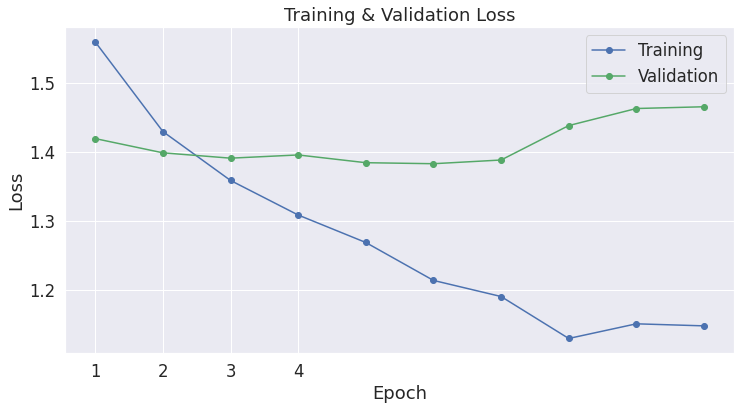

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

5. Performance on Test Set

5.1 Data Preparation

In [24]:
# Create the DataLoader.
prediction_data = val_dataset
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = validation_dataloader

5.2 Evaluate on Test Set

In [25]:
# Prediction on test set

print('Predicting labels for {:,} test reports...'.format(len(val_dataset)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 10 test reports...
    DONE.


Accuracy on the CoLA benchmark is measured using the "[Matthews correlation coefficient](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html)" (MCC).

We use MCC here because the classes are imbalanced:


In [26]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
  # Calculate and store the coef for this batch.  
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


The final score will be based on the entire test set, but let's take a look at the scores on the individual batches to get a sense of the variability in the metric between batches. 

Each batch has 32 sentences in it, except the last batch which has only (516 % 32) = 4 test sentences in it.


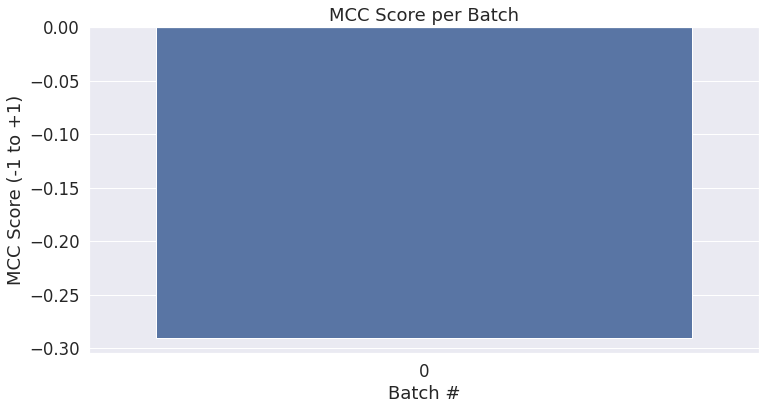

In [27]:
# Create a barplot showing the MCC score for each batch of test samples.
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

plt.show()

In [28]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)

Total MCC: -0.290
